In [56]:
%pylab inline

from datetime import datetime, timedelta
import fpiinfo
from matplotlib import dates
from pyglow import pyglow
import FPIDisplay
import pytz


# Change matplotlib defaults
matplotlib.rcParams['savefig.dpi'] = 150
matplotlib.rcParams['figure.figsize'] = (4,3)
matplotlib.rcParams['font.size'] = 8
matplotlib.rcParams['savefig.bbox'] = 'tight'
matplotlib.rcParams['xtick.labelsize'] = 'small'
matplotlib.rcParams['ytick.labelsize'] = 'small'
matplotlib.rcParams['legend.fancybox'] = 'True'
matplotlib.rcParams['legend.fontsize'] = 'small'
matplotlib.rcParams['legend.numpoints'] = 1

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


Updated load_level0 function to use saved (old) data, as a temporary measure while the FPI database is being reprocessed.

# Look for RENOIR storm data

In [112]:
def load_level0(instr_name, year, doy):
    '''
    Return the contents of the npz file specified by the arguments.
    Access contents with, e.g.,
        output['FPI_Results']
        output['instrument']
        output['site']
    '''
    # Load FPI_Results
    fpi_results_dir =  '/rdata/airglow/fpi/results/old_delete_me/'
    process_dn = datetime(year,1,1) + timedelta(days = doy-1)
    site_name = fpiinfo.get_site_of(instr_name, process_dn)
    datestr = process_dn.strftime('%Y%m%d')
    instrsitedate = instr_name + '_' + site_name + '_' + datestr
    npzfn = fpi_results_dir + instrsitedate + '.npz'
    npzfile = np.load(npzfn)
    
    # Rearrange so it actually looks like a dictionary
    npzdict = {}
    for key in npzfile:
        npzdict[key] = npzfile[key].item()
   
    del npzfile.f 
    npzfile.close()
    return npzdict

In [113]:
def get_level0_fn(instr_name, year, doy):
    fpi_results_dir =  '/rdata/airglow/fpi/results/old_delete_me/'
    process_dn = datetime(year,1,1) + timedelta(days = doy-1)
    site_name = fpiinfo.get_site_of(instr_name, process_dn)
    datestr = process_dn.strftime('%Y%m%d')
    instrsitedate = instr_name + '_' + site_name + '_' + datestr
    npzfn = fpi_results_dir + instrsitedate + '.npz'
    return npzfn

In [114]:
def get_kp_dst(year, doy):
    '''
    Return the max Kp and min Dst in the 24 hours preceding the end of data-taking of 
    the night starting (year, doy). NATION time zone is assumed.
    '''
    # 1 UT on the day data-taking started. Roughly 35 hrs before data-taking stops for NATION.
    tref = datetime(year, 1, 1, 1) + timedelta(days=doy-1)
    kp = []
    dst = []
    for i in range(36): # Search over the range (tref, tref + 36 hrs)
        t = tref + timedelta(hours=i)
        pt = pyglow.Point(t, 0, 0, 250)
        kp.append(pt.kp)
        dst.append(pt.dst)    
    return max(kp),min(dst)


#### Find storm days when data exists at both instruments

In [115]:
years = [2010,2011,2012,2013,2014,2015]
doys = range(1,366)
#years = [2013]
#doys = range(1,366)
kp_thresh = 4.9
instr_names = ['minime01','minime02']


storm_year_doys = []
for year in years:
    for doy in doys:
        kp,dst = get_kp_dst(year, doy)
        if kp >= kp_thresh:
            success = True
            for instr_name in instr_names:
                try:
                    npzfile = load_level0(instr_name,year, doy)
                except:
                    success = False
                
            if success:
                print year, doy, kp
                storm_year_doys.append((year, doy))


2010 216 6.3
2011 35 5.7
2011 96 5.0
2011 101 5.0
2011 102 5.0
2011 211 5.0
2011 217 7.7
2011 218 6.3
2011 252 5.7
2011 253 5.7
2011 259 5.3
2011 260 5.3
2011 269 6.3
2011 270 5.7
2011 271 5.7
2011 272 5.7
2011 297 7.3
2011 298 7.3
2012 45 5.3
2012 46 5.3
2012 50 5.7
2012 58 5.3
2012 67 6.0
2012 69 8.0
2012 71 6.3
2012 72 6.3
2012 75 6.3
2012 77 5.0
2012 87 5.0
2012 114 6.7
2012 115 6.7
2012 116 5.3
2012 154 5.3
2012 163 5.3
2012 164 5.0
2012 168 6.3
2012 169 6.0
2012 170 5.3
2012 190 6.7
2012 191 6.7
2012 196 6.7
2012 197 7.0
2012 198 6.3
2012 246 5.7
2012 247 5.7
2012 248 5.7
2012 249 5.7
2012 318 6.3
2012 319 6.3
2013 59 5.0
2013 60 5.0
2013 75 6.7
2013 76 6.7
2013 88 5.3
2013 89 5.0
2013 114 5.0
2013 121 5.7
2013 144 5.7
2013 145 5.0
2013 151 7.0
2013 152 7.0
2013 157 5.7
2013 158 5.7
2013 179 6.3
2013 180 6.3
2013 196 5.3
2013 227 5.3
2013 228 5.3
2013 239 5.0
2013 274 7.7
2013 275 7.7
2013 281 5.7
2013 282 5.3
2013 312 5.0
2013 313 5.0
2013 341 6.0
2013 342 6.0
2014 46 5.0
2014 4

IndexError: index 30591 is out of bounds for axis 1 with size 30591

In [ ]:
for i in range(len(storm_year_doys)):
#for i in [8]:

    year, doy = storm_year_doys[i]

    instr_names = ['minime01','minime02']

    fig = figure(figsize=(6,9))
    success = True
    for i in range(len(instr_names)):
        instr_name = instr_names[i]
        ax = subplot(3,1,i+2)
        fn = get_level0_fn(instr_name,year,doy)
        try:
            (figT,_),(figw,_) = FPIDisplay.PlotDay(fn,Doppler_Fig=fig,Doppler_Graph=ax)
            ax.legend(prop={'size':6},ncol=5)
        except Exception as e:
            print 'FAILED: (%s,%i,%03i) %s' % (instr_name,year, doy, e)
            success = False
        finally:
            close(figT)
    if success:
        # Make DST plot
        subplot(3,1,1)
        r = load_level0(instr_name, year, doy)['FPI_Results']
        t0 = r['sky_times'][0].astimezone(pytz.utc).replace(tzinfo=None)
        t1 = r['sky_times'][-1].astimezone(pytz.utc).replace(tzinfo=None)
        t00 = datetime(t0.year, t0.month, t0.day, t0.hour) - timedelta(hours=24)
        t_dst = []
        dst = []
        for h in range(48):
            t = t00 + timedelta(hours=h)
            pt = pyglow.Point(t,0,0,200)
            t_dst.append(t)
            dst.append(pt.dst)
        plot(t_dst,dst,'k-')
        plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%d %H'))
        grid()
        ylim((-200,50))
        fill_betweenx([-200, 50],t0,t1,color='gray',alpha=0.3)
        
        tight_layout()
        kp,dst = get_kp_dst(year,doy)
        fig.savefig('/home/bhardin2/ipython_figures/isea_2015/renoir_storm_%i_%03i_Kp%i.png'%(year,doy,round(kp)),\
                    dpi=200)
        print 'SUCCESS: (%i,%03i)' % (year, doy)
    close(fig)
close()

FAILED: (minime01,2010,216) Cannot establish Doppler reference: No trustworthy zenith samples
SUCCESS: (2011,035)
SUCCESS: (2011,096)
FAILED: (minime02,2011,101) Cannot establish Doppler reference: No zenith samples in specified time range

#### Find days when only CAR was operating during storms

In [120]:
years = [2010,2011,2012,2013,2014,2015]
doys = range(1,366)
#years = [2013]
#doys = range(1,366)
q_thresh = 0.
kp_thresh = 5.6
instr_names = ['minime01']


storm_year_doys = []
for year in years:
    for doy in doys:
        kp,dst = get_kp_dst(year, doy)
        if kp >= kp_thresh:
            success = True
            for instr_name in instr_names:
                try:
                    npzfile = load_level0(instr_name,year, doy)
                except:
                    success = False
                
            if success:
                print year, doy, kp
                storm_year_doys.append((year, doy))


2010 216 6.3
2011 35 5.7
2011 217 7.7
2011 218 6.3
2011 252 5.7
2011 253 5.7
2011 269 6.3
2011 270 5.7
2011 271 5.7
2011 272 5.7
2011 297 7.3
2011 298 7.3
2012 49 5.7
2012 50 5.7
2012 66 6.0
2012 67 6.0
2012 68 8.0
2012 69 8.0
2012 71 6.3
2012 72 6.3
2012 75 6.3
2012 114 6.7
2012 115 6.7
2012 168 6.3
2012 169 6.0
2012 190 6.7
2012 191 6.7
2012 196 6.7
2012 197 7.0
2012 198 6.3
2012 246 5.7
2012 247 5.7
2012 248 5.7
2012 249 5.7
2012 318 6.3
2012 319 6.3
2013 75 6.7
2013 76 6.7
2013 121 5.7
2013 144 5.7
2013 151 7.0
2013 152 7.0
2013 157 5.7
2013 158 5.7
2013 179 6.3
2013 180 6.3
2013 274 7.7
2013 275 7.7
2013 281 5.7
2013 341 6.0
2013 342 6.0
2014 49 6.3
2014 50 6.3
2014 51 6.0
2015 6 6.3
2015 7 6.3


IndexError: index 30591 is out of bounds for axis 1 with size 30591

FAILED: (minime01,2010,216) Cannot establish Doppler reference: No trustworthy zenith samples
SUCCESS: (2011,035)
SUCCESS: (2011,217)
SUCCESS: (2011,218)
SUCCESS: (2011,252)
SUCCESS: (2011,253)
SUCCESS: (2011,269)
SUCCESS: (2011,270)
SUCCESS: (2011,271)
SUCCESS: (2011,272)
SUCCESS: (2011,297)
SUCCESS: (2011,298)
SUCCESS: (2012,049)
SUCCESS: (2012,050)
SUCCESS: (2012,066)
SUCCESS: (2012,067)
SUCCESS: (2012,068)
SUCCESS: (2012,069)
SUCCESS: (2012,071)
SUCCESS: (2012,072)
SUCCESS: (2012,075)
SUCCESS: (2012,114)
SUCCESS: (2012,115)
SUCCESS: (2012,168)
SUCCESS: (2012,169)
FAILED: (minime01,2012,190) Cannot establish Doppler reference: No trustworthy zenith samples
FAILED: (minime01,2012,191) Cannot establish Doppler reference: No trustworthy zenith samples
SUCCESS: (2012,196)
SUCCESS: (2012,197)
SUCCESS: (2012,198)
SUCCESS: (2012,246)
SUCCESS: (2012,247)
SUCCESS: (2012,248)
SUCCESS: (2012,249)
SUCCESS: (2012,318)
SUCCESS: (2012,319)
SUCCESS: (2013,075)
SUCCESS: (2013,076)
SUCCESS: (2013,121

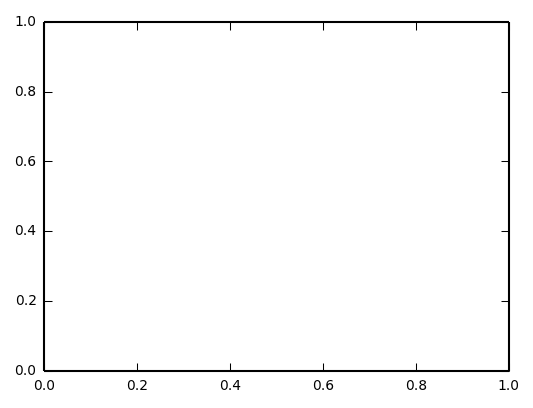

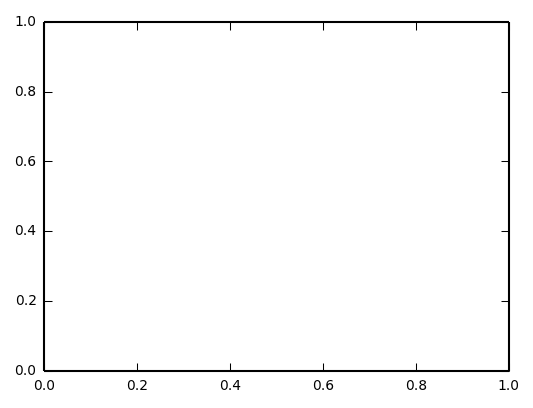

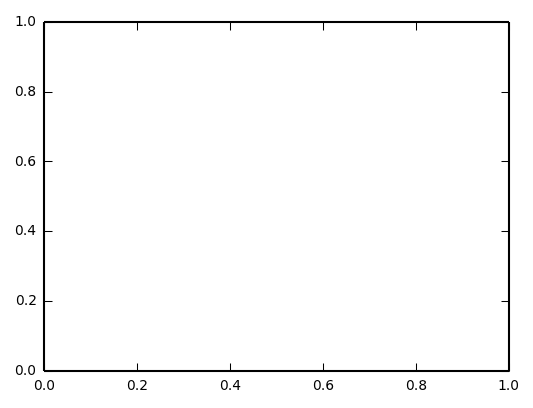

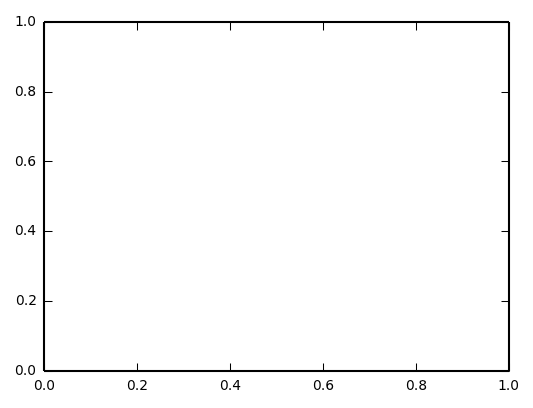

In [122]:
for i in range(len(storm_year_doys)):
#for i in [8]:

    year, doy = storm_year_doys[i]

    instr_names = ['minime01']

    fig = figure(figsize=(6,9))
    success = True
    for i in range(len(instr_names)):
        instr_name = instr_names[i]
        ax = subplot(2,1,i+2)
        fn = get_level0_fn(instr_name,year,doy)
        try:
            (figT,_),(figw,_) = FPIDisplay.PlotDay(fn,Doppler_Fig=fig,Doppler_Graph=ax)
            ax.legend(prop={'size':6},ncol=5)
        except Exception as e:
            print 'FAILED: (%s,%i,%03i) %s' % (instr_name,year, doy, e)
            success = False
        finally:
            close(figT)
    if success:
        # Make DST plot
        subplot(2,1,1)
        r = load_level0(instr_name, year, doy)['FPI_Results']
        t0 = r['sky_times'][0].astimezone(pytz.utc).replace(tzinfo=None)
        t1 = r['sky_times'][-1].astimezone(pytz.utc).replace(tzinfo=None)
        t00 = datetime(t0.year, t0.month, t0.day, t0.hour) - timedelta(hours=24)
        t_dst = []
        dst = []
        for h in range(48):
            t = t00 + timedelta(hours=h)
            pt = pyglow.Point(t,0,0,200)
            t_dst.append(t)
            dst.append(pt.dst)
        plot(t_dst,dst,'k-')
        plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%d %H'))
        grid()
        ylim((-200,50))
        fill_betweenx([-200, 50],t0,t1,color='gray',alpha=0.3)
        
        tight_layout()
        kp,dst = get_kp_dst(year,doy)
        fig.savefig('/home/bhardin2/ipython_figures/isea_2015/renoir_stormCAR_%i_%03i_Kp%i.png'%(year,doy,round(kp)),\
                    dpi=200)
        print 'SUCCESS: (%i,%03i)' % (year, doy)
    close(fig)
close()

# RENOIR Map 

In [97]:
def cnv_azel2latlon(az, el, ht, site):
    '''
    Function to convert from an azimuth/elevation grid to a
    latitude/longitude grid given an unwarping height and a site location.
    For elevations below the horizon, returns NaN.
    INPUTS:
        az - M x N array of azimuths to be converted [degrees]
        el - M x N array of elevation to be converted [degrees]
        ht - M x N array of heights to be used in the conversion [km]
        site - 1 x 2 array containing [latitude, longitude] of the site
           [degrees]

    OUTPUTS:
        lat - M x N array of latitudes [degrees]
        lon - M x N array of longitudes [degrees]

    HISTORY:
        17-Oct-2006: Converted from IDL by Jonathan J. Makela
        (jmakela@uiuc.edu)
        03-Oct-2013: Converted from MATLAB to Python by Brian Harding

    '''
    Re = 6371.2 # radius of Earth in km
    
    # Convert inputs from degrees to radians
    el_r = el*np.pi/180.
    az_r = az*np.pi/180.
    lat_r = site[0]*pi/180.
    lon_r = site[1]*pi/180.
    
    # Calculate the differential angle, alpha
    temp = np.cos(el_r)/(1.+(ht/Re))
    alpha = np.arccos(temp) - el_r

    # Calculate the pierce point latitude
    temp = np.sin(lat_r) * np.cos(alpha) + np.cos(lat_r)*np.cos(az_r)*np.sin(alpha)
    lat_r = np.arcsin(temp)

    # Calculate the pierce point longitude
    temp = np.sin(alpha) * np.sin(az_r) / np.cos(lat_r)
    lon_r = np.arcsin(temp) + lon_r

    # Convert radian measurements to degrees
    lat = lat_r*180./pi
    lon = lon_r*180./pi
    
    #i = np.where(el < -1)
    #lat[i] = np.nan
    #lon[i] = np.nan
    
    return lat,lon

In [101]:
######################################################################################
instr_names = ['minime0%i' % i for i in [1,2]]
year = 2012
doy = 248

#year = 2014
#doy = 40

# tbounds: see function below
#tbounds = [ [0, 2], [9, 12] ] # intervals to trust that avg vertical wind = 0 (UT, inclusive)
# degree: see function below
#degree = 1 # degree of polynomial to fit to vertical winds for doppler referencing
######################################################################################

def get_tbounds(instr_name):
    '''
    Return the intervals to trust that the avg vertical wind = 0
    (UT, inclusive)
    '''
    tbounds = [[0,1]]
    # TEMPORARY: UNCOMMENT ME FOR OCT 2 STORM
    if instr_name == 'minime08':
        # ANN has some laser drift that needs correcting
        tbounds.append([9,12])
    return tbounds

def get_degree(instr_name):
    '''
    Return the degree of the polynomial to be used to fit
    to zenith winds for Doppler reference removal.
    '''
    if instr_name == 'minime08':
        # ANN has some laser drift that needs correcting
        degree = 1
    else:
        degree = 0
    return degree


ht = 250

import FPIprocess
from scipy import interpolate
import pytz

# Create reference time
t0 = datetime(2013,10,2,0,0,0) # totally arbitrary

locs = [] # This will have one entry for every airglow pierce point

for instr_name in instr_names:
    
    r = FPIprocess.load_level0(instr_name, year, doy)
    fpir  = r['FPI_Results']
    site = r['site']
    direction = fpir['direction']
    LOSwind = fpir['LOSwind']
    sigma_LOSwind = fpir['sigma_LOSwind']
    sigma_T = fpir['sigma_T']
    I = fpir['skyI']/fpir['sky_intT']
    
    
    # Sort into look directions
    LOSw = {}
    LOSwe = {}
    LOST = {}
    LOSTe = {}
    LOSI = {}
    uniqdirection = list(set(direction))
    for direc in uniqdirection:
        LOSw[direc] = array([w for (w,d) in zip(LOSwind,direction) if d==direc])
        LOSwe[direc] = array([w for (w,d) in zip(sigma_LOSwind,direction) if d==direc])
        #LOST[direc] = array([w for (w,d) in zip(T,direction) if d==direc])
        #LOSTe[direc] = array([w for (w,d) in zip(sigma_T,direction) if d==direc])
        #LOSI[direc] = array([w for (w,d) in zip(Ifixed,direction) if d==direc])
        
    # Grab times (in UT, time-zone naive)
    t_all = [time.astimezone(pytz.utc).replace(tzinfo=None) for time in fpir['sky_times']]
        
    # sort by direction
    t = {}
    for direc in uniqdirection:
        t[direc] = array([w for (w,d) in zip(t_all,direction) if d==direc])
    
    # Make interpolation objects 

    for d in uniqdirection:
        loc = {}
        az = site['Directions'][d]['az']
        ze = site['Directions'][d]['ze']
        if ze < 0:
            az = az + 180
            ze = -ze
        latx, lonx = cnv_azel2latlon(az, 90-ze, ht, (site['Location'][0], site['Location'][1]))
        loc['lat'] = latx
        loc['lon'] = lonx
        loc['site'] = site['Abbreviation']
        loc['direc'] = d
        loc['az'] = az
        loc['ze'] = ze
        # Create wind interpolation
        t_seconds = array([(time - t0).total_seconds() for time in t[d]])
        loc['wind'] = interpolate.interp1d(t_seconds, LOSw[d], bounds_error=False) # TODO: set bound_error value
        #loc['T'] = interpolate.interp1d(t_seconds, LOST[d], bounds_error=False)
        #loc['I'] = interpolate.interp1d(t_seconds, LOSI[d], bounds_error=False)
        loc['times_sec'] = t_seconds
        loc['times'] = t[d]
        locs.append(loc)


In [102]:
markers = {
           'car': ('D',75),
           'caj': ('o',75),
           }
cols = {
           'car': 'g',
           'caj': 'r',
           }

lats = []
lons = []
site_names = markers.keys()
site_names = ['car','caj']
for site_name in site_names:
    site = fpiinfo.get_site_info(site_name)
    lat,lon,_ = site['Location']
    lats.append(lat)
    lons.append(lon)
lats = array(lats)
lons = array(lons)

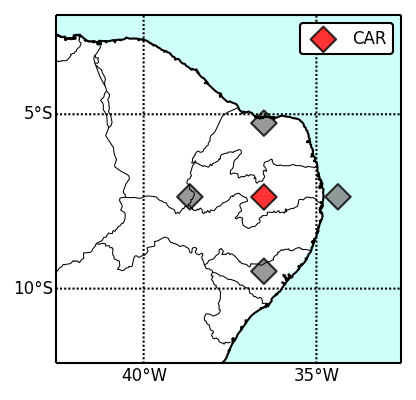

In [110]:
from mpl_toolkits.basemap import Basemap

figsize=(3,3)

lats = array([loc['lat'] for loc in locs])
lons = array([loc['lon'] for loc in locs])
latref = lats.mean()
lonref = lons.mean()


fig = figure(num=None, figsize=figsize, dpi=80, facecolor='w', edgecolor='k')

#### Figure 1: lat/lon ####
#ax1 = subplot2grid((4,1),(0,0), rowspan=3)

#ax = subplot2grid((4,1),(0,0), rowspan=3)
# setup Lambert Conformal basemap.
m = Basemap(llcrnrlon=lonref-5.,llcrnrlat=latref-5.,urcrnrlon=lonref+5.,urcrnrlat=latref+5.,
        projection='merc', area_thresh=1000,
        resolution='i',lat_1=-15.,lat_2=5,lat_0=-7,lon_0=-37.)
# draw coastlines and fill the continents (alpha value is set to partial transparancy because for some
# reason the fill is over top the quivers used to denote the wind vectors
m.drawcoastlines()
#m.fillcontinents(color='none',lake_color='gray',alpha=0.5)
m.drawlsmask(land_color='none',ocean_color=array([207,255,251])/255.,lakes=True)
m.drawstates()

# draw parallels and meridians.
# label parallels on left and bottom
# meridians on bottom and left
# labels = [left,right,top,bottom]
parallels = np.arange(-80.,81,5.)
m.drawparallels(parallels,labels=[True,False,False,True])
meridians = np.arange(-180.,0.,5.)
m.drawmeridians(meridians,labels=[True,False,False,True])
#cb.set_alpha(1)

for loc in locs:
    xpt, ypt = m(loc['lon'], loc['lat'])
    marker, size = markers[loc['site']]
    if loc['site']=='car':
        if loc['direc'] == 'Zenith':
            m.scatter(xpt,ypt, marker=marker, c='r', s = size, edgecolor='k', alpha = 0.8, label=loc['site'].upper())
        else:
            m.scatter(xpt,ypt, marker=marker, c=0.5*ones(3), s = size, edgecolor='k', alpha = 0.8)


legend(loc='upper right', scatterpoints = 1, prop={'size':8} ,framealpha=1)

fig.savefig('/home/bhardin2/ipython_figures/isea_2015/RENOIR_single.eps')

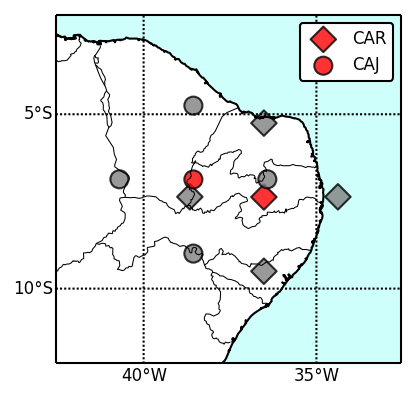

In [111]:
from mpl_toolkits.basemap import Basemap

figsize=(3,3)

lats = array([loc['lat'] for loc in locs])
lons = array([loc['lon'] for loc in locs])
latref = lats.mean()
lonref = lons.mean()


fig = figure(num=None, figsize=figsize, dpi=80, facecolor='w', edgecolor='k')

#### Figure 1: lat/lon ####
#ax1 = subplot2grid((4,1),(0,0), rowspan=3)

#ax = subplot2grid((4,1),(0,0), rowspan=3)
# setup Lambert Conformal basemap.
m = Basemap(llcrnrlon=lonref-5.,llcrnrlat=latref-5.,urcrnrlon=lonref+5.,urcrnrlat=latref+5.,
        projection='merc', area_thresh=1000,
        resolution='i',lat_1=-15.,lat_2=5,lat_0=-7,lon_0=-37.)
# draw coastlines and fill the continents (alpha value is set to partial transparancy because for some
# reason the fill is over top the quivers used to denote the wind vectors
m.drawcoastlines()
#m.fillcontinents(color='none',lake_color='gray',alpha=0.5)
m.drawlsmask(land_color='none',ocean_color=array([207,255,251])/255.,lakes=True)
m.drawstates()

# draw parallels and meridians.
# label parallels on left and bottom
# meridians on bottom and left
# labels = [left,right,top,bottom]
parallels = np.arange(-80.,81,5.)
m.drawparallels(parallels,labels=[True,False,False,True])
meridians = np.arange(-180.,0.,5.)
m.drawmeridians(meridians,labels=[True,False,False,True])
#cb.set_alpha(1)

for loc in locs:
    xpt, ypt = m(loc['lon'], loc['lat'])
    marker, size = markers[loc['site']]
    if loc['direc'] == 'Zenith':
        m.scatter(xpt,ypt, marker=marker, c='r', s = size, edgecolor='k', alpha = 0.8, label=loc['site'].upper())
    else:
        m.scatter(xpt,ypt, marker=marker, c=0.5*ones(3), s = size, edgecolor='k', alpha = 0.8)


legend(loc='upper right', scatterpoints = 1, prop={'size':8} ,framealpha=1)

fig.savefig('/home/bhardin2/ipython_figures/isea_2015/RENOIR_full.eps')

# Mapping method development plots

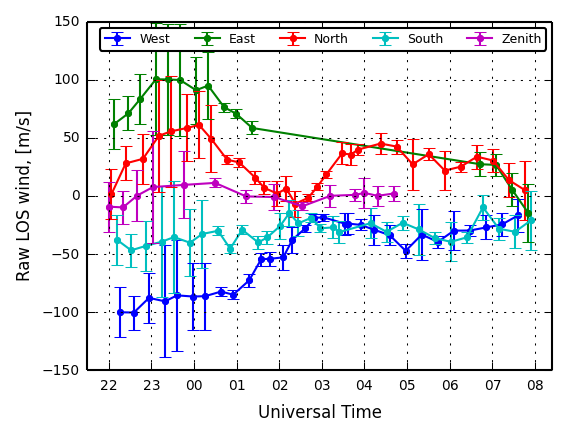

In [131]:
instr_name = 'minime01'
year = 2013
doy = 32

import FPI


r = load_level0(instr_name, year, doy)
fpir  = r['FPI_Results']
site = r['site']



direction = fpir['direction']
LOSwind = fpir['LOSwind']
sigma_LOSwind = fpir['sigma_LOSwind']
T = fpir['T']
sigma_T = fpir['sigma_T']
I = fpir['skyI']/fpir['sky_intT']
sky_times = fpir['sky_times']
skyI = fpir['skyI']
skyB = fpir['skyB']
sigma_skyI = fpir['sigma_skyI']
intT = fpir['sky_intT']
cloud = None
sky_fns = fpir['sky_fns']
if fpir['Clouds']:
    cloud = fpir['Clouds']['mean']

from matplotlib import dates

fig = figure(figsize=(4,3))
ax = subplot(111)
dref, drefe = FPI.DopplerReference(fpir, reference='laser',AVERAGING_TIME=[20.,29.])
LOSwind_ref = LOSwind - dref
for direc in list(set(direction)):
    I = np.array([si for (si,d) in zip(LOSwind_ref, direction) if d == direc])
    Ie = np.array([si for (si,d) in zip(sigma_LOSwind, direction) if d == direc])
    t = np.array([si for (si,d) in zip(sky_times, direction) if d == direc])
    ax.errorbar(t, I, yerr=Ie, fmt='.-', label=direc)
ax.set_xlim([sky_times[0] - timedelta(hours=0.5), sky_times[-1] + timedelta(hours=0.5)])
#ax.set_ylim((prctile(LOSwind,5)-100,prctile(LOSwind,95)+100))
ax.xaxis.set_major_formatter(dates.DateFormatter('%H'))
ax.set_ylabel('Raw LOS wind, [m/s]')
ax.set_xlabel('Universal Time')
ax.legend(loc='upper center', prop={'size':6}, numpoints=1, ncol=5, framealpha=1)
ax.grid(True)
ax.set_ylim((-150,150))

savefig('/home/bhardin2/ipython_figures/isea_2015/%s_los_%i_%03i.pdf' % (instr_name,year, doy))

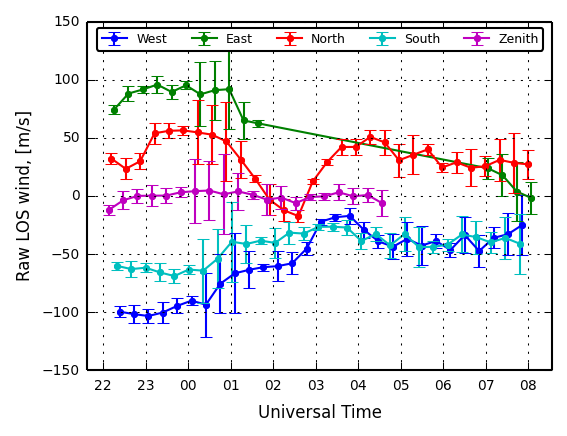

In [133]:
instr_name = 'minime02'
year = 2013
doy = 32

import FPI


r = load_level0(instr_name, year, doy)
fpir  = r['FPI_Results']
site = r['site']



direction = fpir['direction']
LOSwind = fpir['LOSwind']
sigma_LOSwind = fpir['sigma_LOSwind']
T = fpir['T']
sigma_T = fpir['sigma_T']
I = fpir['skyI']/fpir['sky_intT']
sky_times = fpir['sky_times']
skyI = fpir['skyI']
skyB = fpir['skyB']
sigma_skyI = fpir['sigma_skyI']
intT = fpir['sky_intT']
cloud = None
sky_fns = fpir['sky_fns']
if fpir['Clouds']:
    cloud = fpir['Clouds']['mean']

from matplotlib import dates

fig = figure(figsize=(4,3))
ax = subplot(111)
dref, drefe = FPI.DopplerReference(fpir, reference='laser',AVERAGING_TIME=[20.,29.])
LOSwind_ref = LOSwind - dref
for direc in list(set(direction)):
    I = np.array([si for (si,d) in zip(LOSwind_ref, direction) if d == direc])
    Ie = np.array([si for (si,d) in zip(sigma_LOSwind, direction) if d == direc])
    t = np.array([si for (si,d) in zip(sky_times, direction) if d == direc])
    ax.errorbar(t, I, yerr=Ie, fmt='.-', label=direc)
ax.set_xlim([sky_times[0] - timedelta(hours=0.5), sky_times[-1] + timedelta(hours=0.5)])
#ax.set_ylim((prctile(LOSwind,5)-100,prctile(LOSwind,95)+100))
ax.xaxis.set_major_formatter(dates.DateFormatter('%H'))
ax.set_ylabel('Raw LOS wind, [m/s]')
ax.set_xlabel('Universal Time')
ax.legend(loc='upper center', prop={'size':6}, numpoints=1, ncol=5, framealpha=1)
ax.grid(True)
ax.set_ylim((-150,150))

savefig('/home/bhardin2/ipython_figures/isea_2015/%s_los_%i_%03i.pdf' % (instr_name,year, doy))

# No structure seen in DD. In fact, we see a very small DD effect.

In [ ]:
# The proof of that first statement is elsewhere. Proven by looking at the quicklook plots and seeing nothing.
# Of course, this could be due to low-quality measurements or low-resolution. But certainly there's nothing on 
# the scale of the structure seen in the MTM.

# How big is the DD? No need for mapping...

In [119]:
# Is this a waste of time? For now yes. 

# DD figures

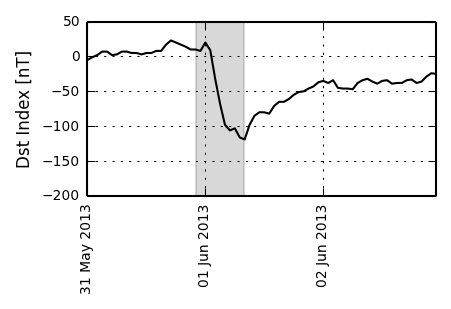

In [144]:
instr_name = 'minime01'
year = 2013
doy = 151

figure(figsize=(3,1.5))
r = load_level0(instr_name, year, doy)['FPI_Results']
t0 = r['sky_times'][0].astimezone(pytz.utc).replace(tzinfo=None)
t1 = r['sky_times'][-1].astimezone(pytz.utc).replace(tzinfo=None)
t00 = datetime(t0.year, t0.month, t0.day) - timedelta(hours=0)
t_dst = []
dst = []
for h in range(72):
    t = t00 + timedelta(hours=h)
    pt = pyglow.Point(t,0,0,200)
    t_dst.append(t)
    dst.append(pt.dst)
plot(t_dst,dst,'k-')
#plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%d %H'))
grid()
ylim((-200,50))
fill_betweenx([-200, 50],t0,t1,color='gray',alpha=0.3)
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%d %b %Y'))
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
ylabel('Dst Index [nT]')

xticks([t00, t00+timedelta(days=1), t00+timedelta(days=2)])
savefig('/home/bhardin2/ipython_figures/isea_2015/dst_%i_%03i.pdf' % (year, doy))

In [146]:
import FPIwindfield

wf = FPIwindfield.WindField(['renoir'], 2013,151, 
                cloudthresh=-5, timestep_fit=900, startstop_hr = None , errbarthresh=np.inf,
                Nx=30, Ny=30, printstuffouter = False, estimate_vertical_wind=False,
                estimate_uncertainty=False)

wf.run_inversion()

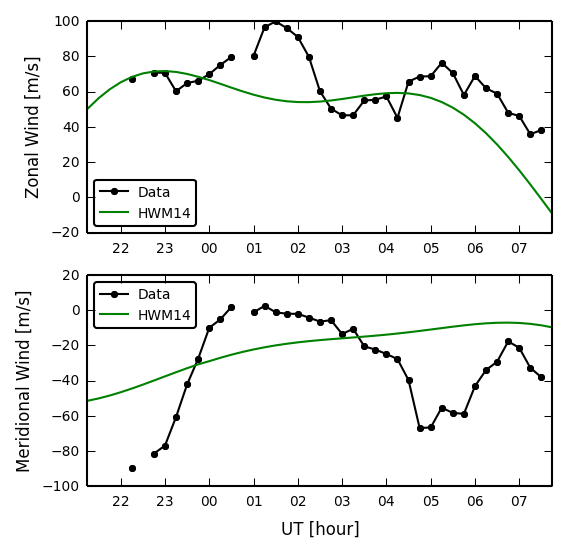

In [156]:
from pyglow import pyglow
lon = mean(wf.lons)
lat = mean(wf.lats)
t = wf.windfield['t']

u_wf = zeros(len(t))
v_wf = zeros(len(t))
u_hwm = zeros(len(t))
v_hwm = zeros(len(t))

for i in range(len(t)):
    x = wf.eval_field(lon, lat, t[i].replace(tzinfo=None))
    u_wf[i] = x[0]
    v_wf[i] = x[1]
    
    pt = pyglow.Point(t[i].replace(tzinfo=None), lat, lon, 250)
    pt.ap = 0.0
    pt.run_hwm14()
    u_hwm[i] = pt.u
    v_hwm[i] = pt.v
    
figure(figsize=(4,4))

subplot(2,1,1)
plot(t,u_wf,'k.-',label='Data', )
plot(t,u_hwm,'g-',label='HWM14')
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H'))
ylabel('Zonal Wind [m/s]')
legend(loc='best')

subplot(2,1,2)
plot(t,v_wf,'k.-',label='Data')
plot(t,v_hwm,'g-',label='HWM14')
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H'))
ylabel('Meridional Wind [m/s]')
legend(loc='best')


xlabel('UT [hour]')

savefig('/home/bhardin2/ipython_figures/isea_2015/hwmcompare_%i_%03i.pdf' % (year, doy))

In [168]:
from pyglow import pyglow
from Scientific.IO.NetCDF import NetCDFFile as Dataset
import numpy as np
from scipy import interpolate
from scipy.io import readsav # read IDL save files
from datetime import datetime, timedelta
import glob
from matplotlib import dates
import FPIprocess
import FPI
import pytz
import TWINS
from spacepy import pycdf

def plot_fpi(fpiyears, fpidoys, instr_names):
    #instr_names = ['minime05','minime06','minime08','minime09']
    figure(figsize=(3.5,2))
    
    fpi = {}
    site_names = {}
    for instr_name in instr_names:
        fpi[instr_name] = {}
        fpi[instr_name]['t'] = []
        fpi[instr_name]['w'] = []
        fpi[instr_name]['we'] = []
        fpi[instr_name]['c'] = []
        fpi[instr_name]['las_drift'] = []
        fpi[instr_name]['q'] = [] # quality flag


        for fpiyear, fpidoy in zip(fpiyears,fpidoys):
            success = True
            try:
                npzfile = FPIprocess.load_level0(instr_name, fpiyear, fpidoy)
                fpir = npzfile['FPI_Results']
                #dref,drefe = FPI.DopplerReference(fpir, reference=fpir['reference'])
                if fpir['reference']=='zenith':
                    raise Exception('Zenith reference: ignore')
            except Exception as e:
                #print '%s_%i_%03i Failed: %s' % (instr_name, fpiyear, fpidoy, e)
                success = False
            if success:
                fpi_tall = fpir['sky_times']
                fpi_direcs = fpir['direction']
                site_names[instr_name] = npzfile['site']['Abbreviation'].upper()
                if 'Zenith' in fpi_direcs: # Only use nights that took zenith measurements
                    fpi_wall = fpir['LOSwind']# - dref
                    #fpi_weall = fpir['sigma_fit_LOSwind']
                    fpi_weall = fpir['sigma_LOSwind']
                    #if 'wind_quality_flag' not in fpir.keys():
                    #    print 'OLD:',fpiyear,fpidoy,instr_name
                    ##### HACK OF THE CENTURY #####
                    if fpiyear == 2012 and fpidoy == 318 and instr_name == 'minime05':
                        print 'WARNING: DOPPLER REF MANUALLY CHANGED'
                        fpi_wall -= 50.
                    if fpiyear == 2013 and fpidoy == 151 and instr_name == 'minime08':
                        print 'WARNING: DOPPLER REF MANUALLY CHANGED'
                        fpi_wall -= 100.
                    ###############################
                    fpi_qall  = fpir['wind_quality_flag']
                    fpi_cloudall = nan*zeros(len(fpi_tall))
                    if fpir['Clouds'] is not None:
                        fpi_cloudall = fpir['Clouds']['mean']
                    fpi_w = array([w for (w,d) in zip(fpi_wall, fpi_direcs) if d == 'Zenith'])
                    fpi_t = array([w for (w,d) in zip(fpi_tall, fpi_direcs) if d == 'Zenith'])
                    fpi_we = array([w for (w,d) in zip(fpi_weall, fpi_direcs) if d == 'Zenith'])
                    fpi_c = array([w for (w,d) in zip(fpi_cloudall, fpi_direcs) if d == 'Zenith'])
                    fpi_q = array([w for (w,d) in zip(fpi_qall, fpi_direcs) if d == 'Zenith'])
                    fpi[instr_name]['t'].append(fpi_t)
                    fpi[instr_name]['w'].append(fpi_w)
                    fpi[instr_name]['we'].append(fpi_we)
                    fpi[instr_name]['c'].append(fpi_c)
                    fpi[instr_name]['q'].append(fpi_q)
                    #las_drift_flag = laser_is_drifting(instr_name, fpiyear, fpidoy)
                    #fpi[instr_name]['las_drift'].append(las_drift_flag)
                    #if las_drift_flag:
                    #    print 'Laser drift detected: %s_%s_%s' % (instr_name, fpiyear, fpidoy)


    #cols = ['k','r','g','b','y']
    for ii in range(len(instr_names)):
        instr_name = instr_names[ii]
        nn = len(fpi[instr_name]['t']) # number of nights of data available for this instr
        for jj in range(nn):
            # Plot it
            fpi_t = fpi[instr_name]['t'][jj]
            fpi_tutc = [ti.astimezone(pytz.utc).replace(tzinfo=None) for ti in fpi_t]
            fpi_thr = array([(ti-datetime(fpi_t[0].year, fpi_t[0].month,\
                                          fpi_t[0].day)).total_seconds()/3600 for ti in fpi_tutc])
            fpi_w = fpi[instr_name]['w'][jj]
            fpi_we = fpi[instr_name]['we'][jj]
            fpi_c = fpi[instr_name]['c'][jj]
            fpi_q = fpi[instr_name]['q'][jj]
            #for kk in range(len(fpi_t)):
            #    alpha = (2.-fpi_q[kk])/2
            #    alpha = 1.0
            #    scatter(fpi_t[kk],fpi_w[kk],s=2,color='%s'%cols[site_names[instr_name].lower()],alpha=alpha)
            #plot(fpi_t,fpi_w,'%s-' % cols[site_names[instr_name].lower()], linewidth=0.5,alpha=0.5)
            (_,caps,_) = errorbar(fpi_t,fpi_w, fmt='%s.-' % cols[site_names[instr_name].lower()], markersize=5,
                                  linewidth=1.0,alpha=1.0,yerr=fpi_we, label = site_names[instr_name])
            for cap in caps:
                cap.set_markeredgewidth(0)
            #if jj==0:
            #    plot([fpi_t[0],fpi_t[-1]],[nan,nan],
            #         '%so'%cols[site_names[instr_name].lower()],label=site_names[instr_name])

    ylabel('FPI Apparent\nVertical Wind [m/s]')
    legend(loc='lower left', prop={'size':12}, numpoints=1,  fancybox=True, framealpha=1)
    tpre = datetime(fpi_t[-1].year, fpi_t[-1].month, fpi_t[-1].day) - timedelta(hours=4)
    tpost = tpre + timedelta(hours=12)
    xlim((tpre,tpost));
    gca().xaxis.set_major_formatter(dates.DateFormatter('%H'))
    grid()
    ylim((-250,50))
    title('%s' % (tpre.strftime('%d %b %Y')))
    xlabel('UT [hours]')


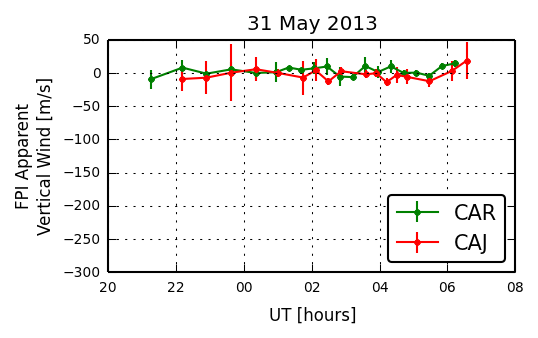

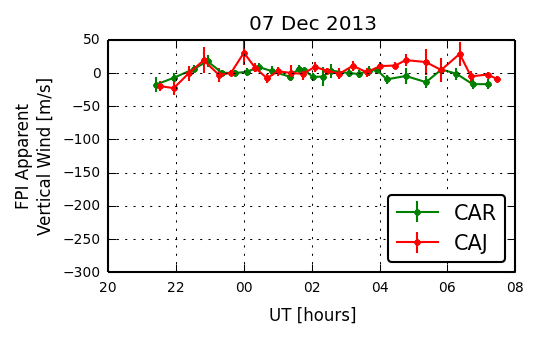

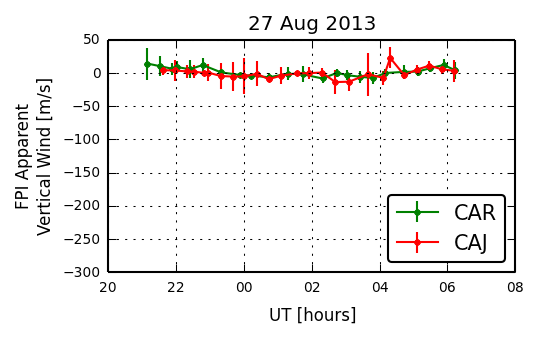

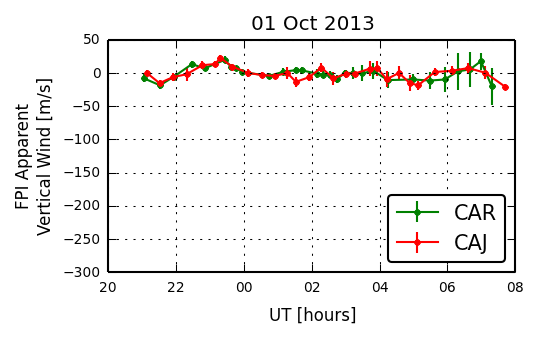

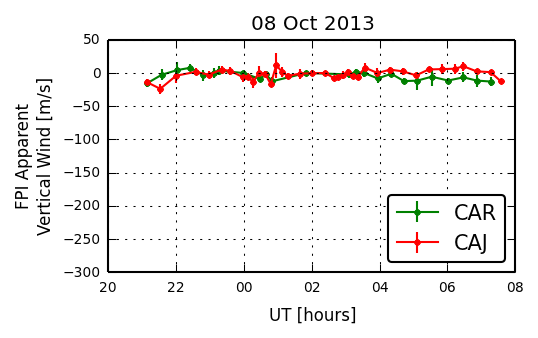

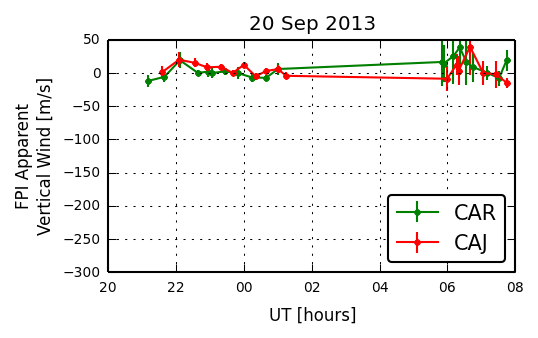

In [169]:
instr_nums = [1,2]

years = [2013, 2013, 2013, 2013, 2013, 2013]
doys =  [151,   341,  239,  274,  281,  263]

for j in range(len(years)):
    year = years[j]
    doy = doys[j]

    instr_names = ['minime%02i'%i for i in instr_nums]
    plot_fpi([year], [doy], instr_names)
    legend(loc='lower right', prop={'size':10}, numpoints=1,  fancybox=True, framealpha=1)
    ylim((-300,50))

    savefig('/home/bhardin2/ipython_figures/isea_2015/vertwind_%i_%03i.pdf' % (year, doy))